In [212]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

pd.pandas.set_option('display.max_columns', None)

In [213]:
df = pd.read_csv('../data/sample.csv')
df.head()
print(df.shape)

(29236, 17)


## 1. Add ID, deal with data recording errors, convert datetime

In [214]:
def add_id(df):
    df = df.copy()
    df['id'] = df.index + 1
    
    return df

df = add_id(df)
print(df.shape)
df.head()

(29236, 18)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,id
0,2,2017-03-06 12:10,2017-03-06 12:20,2,2.03,1,N,140,236,1,9.0,0.0,0.5,1.96,0.0,0.3,11.76,1
1,1,2017-06-14 8:11,2017-06-14 8:14,1,0.40,1,N,43,142,1,4.5,0.0,0.5,1.05,0.0,0.3,6.35,2
2,2,2017-11-22 19:42,2017-11-22 19:49,3,1.04,1,N,151,238,1,6.5,1.0,0.5,0.00,0.0,0.3,8.30,3
3,2,2017-11-12 16:58,2017-11-12 17:09,1,1.79,1,N,239,236,2,9.5,0.0,0.5,0.00,0.0,0.3,10.30,4
4,1,2017-06-14 22:01,2017-06-14 22:06,1,1.20,1,N,246,246,1,6.0,0.5,0.5,2.15,0.0,0.3,9.45,5


In [215]:
def remove_invalid_neg(df, cols):
    """
    Remove negative values columns where it is not possible to have negative values
    """
    for col in cols:
        df = df[df[col] >= 0]
    
    return df

neg_cols = ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']
df = remove_invalid_neg(df, neg_cols)
print(df.shape)

(29221, 18)


In [216]:
def remove_invalid_zeroes(df, cols):
    """
    Remove zero values from where it is not possible to have zero values
    """
    for col in cols:
        df = df[df[col] > 0]
    
    return df

zero_cols = ['fare_amount', 'total_amount']
df = remove_invalid_zeroes(df, zero_cols)
print(df.shape)

(29208, 18)


In [217]:
def remove_error_RatecodeID(df):
    """
    Remove the one erroenous coding instance 
    """
    
    df = df[df.RatecodeID != 99]
    
    return df

df = remove_error_RatecodeID(df)

In [218]:
def convert_datetime(df, cols):
    """
    Extracts time information from the datetime variables. 
    """
    df = df.copy()
    
    for col in cols:
        df[col] = pd.to_datetime(df[col])
    
    return df
    
time_cols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']
df = convert_datetime(df, time_cols)

In [219]:
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,id
count,29207.000000,29207.000000,29207.000000,29207.000000,29207.000000,29207.000000,29207.000000,29207.000000,29207.000000,29207.000000,29207.000000,29207.000000,29207.000000,29207.000000,29207.000000
mean,1.541309,1.630157,2.948309,1.042113,162.780909,161.145376,1.326326,20.613453,0.332232,0.497809,1.886482,0.336510,0.299969,23.970168,14619.143151
std,0.498299,1.270682,3.799932,0.294800,66.426698,70.243998,0.487704,1277.422133,0.446744,0.033028,2.658190,1.501481,0.003040,1277.434953,8441.029991
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.310000,1.000000
25%,1.000000,1.000000,0.980000,1.000000,114.000000,112.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.750000,7308.500000
50%,2.000000,1.000000,1.600000,1.000000,162.000000,162.000000,1.000000,9.500000,0.000000,0.500000,1.400000,0.000000,0.300000,11.800000,14619.000000
75%,2.000000,2.000000,3.020000,1.000000,233.000000,233.000000,2.000000,15.000000,0.500000,0.500000,2.460000,0.000000,0.300000,17.850000,21929.500000
max,2.000000,6.000000,72.680000,5.000000,265.000000,265.000000,4.000000,218316.300000,4.500000,0.500000,100.300000,25.000000,0.300000,218317.090000,29236.000000


## 2. Train test split

- Train on March, validate on June, test on November

In [220]:
train = df[df.tpep_dropoff_datetime <= pd.to_datetime('2017-06-30')]
test = df[df.tpep_dropoff_datetime >= pd.to_datetime('2017-11-01')]

val = train[train.tpep_dropoff_datetime >= pd.to_datetime('2017-06-01')]
train = train[train.tpep_dropoff_datetime < pd.to_datetime('2017-06-01')]

train.shape, val.shape, test.shape

((10132, 18), (9483, 18), (9293, 18))

In [221]:
train.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,id
0,2,2017-03-06 12:10:00,2017-03-06 12:20:00,2,2.03,1,N,140,236,1,9.0,0.0,0.5,1.96,0.0,0.3,11.76,1
10,2,2017-03-06 18:12:00,2017-03-06 18:22:00,1,2.96,1,N,87,79,1,11.0,1.0,0.5,1.00,0.0,0.3,13.80,11
12,1,2017-03-10 18:28:00,2017-03-10 18:43:00,1,1.00,1,N,107,186,2,10.0,1.0,0.5,0.00,0.0,0.3,11.80,13
13,2,2017-03-11 11:04:00,2017-03-11 11:19:00,1,3.12,1,N,224,48,2,13.5,0.0,0.5,0.00,0.0,0.3,14.30,14
14,2,2017-03-20 16:44:00,2017-03-20 16:56:00,1,2.12,1,N,236,236,1,10.0,1.0,0.5,2.36,0.0,0.3,14.16,15


### Time variable

In [222]:
def trip_length(df, start, end):
    """
    start: pickup time
    end: dropoff time
    
    Extracts time information from the two variables. 
    """
    df = df.copy()
    
    df['trip_time'] =  df[end] - df[start]
    
    # convert to seconds
    df['trip_seconds'] = df['trip_time'].astype('timedelta64[s]')
        
    df = df.drop(columns=['trip_time'])
    
    return df

In [223]:
train = trip_length(train, 'tpep_pickup_datetime', 'tpep_dropoff_datetime')
val = trip_length(val, 'tpep_pickup_datetime', 'tpep_dropoff_datetime')
test = trip_length(test, 'tpep_pickup_datetime', 'tpep_dropoff_datetime')

In [224]:
def remove_zero_or_neg_time(df, col):
    """
    In the feature engineered `trip_seconds` column,
    there are negative or zero values to be removed.
    """
    
    df = df[df[col] > 0]
    
    return df
    
train = remove_zero_or_neg_time(train, 'trip_seconds')
val = remove_zero_or_neg_time(val, 'trip_seconds')
test = remove_zero_or_neg_time(test, 'trip_seconds')

In [225]:
def extract_time(df):
    """
    Extract:
    - hour, min, second of the day
    - day of the month 
    """
    
    df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
    df['pickup_min'] = df['tpep_pickup_datetime'].dt.minute
    df['pickup_sec'] = df['tpep_pickup_datetime'].dt.second
    
    df['dropoff_hour'] = df['tpep_dropoff_datetime'].dt.hour
    df['dropoff_min'] = df['tpep_dropoff_datetime'].dt.minute
    df['dropoff_sec'] = df['tpep_dropoff_datetime'].dt.second
    
    df['trip_day'] = df['tpep_dropoff_datetime'].dt.day
    
    df = df.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
    
    return df

train = extract_time(train)
val = extract_time(val)
test = extract_time(test)

In [226]:
train.shape, val.shape, test.shape

((10081, 24), (9434, 24), (9233, 24))

### Numerical variables
- Log transform those without zeros to get a more Gaussian distribution to help linear machine learning models

In [227]:
def log_transform(df, cols):
    """
    log transform numeric variables that do not contain zeros
    """
    
    for col in cols:
        df[col] = np.log(df[col])

    return df

log_vars = ['fare_amount', 'total_amount']

train = log_transform(train, log_vars)
val = log_transform(val, log_vars)
test = log_transform(test, log_vars)

### Categorical variables
- convert strings to numbers to capture monotonic relationship between label and target

In [228]:
# a few variables have been coded as an int instead of a categorical variable
var_to_str = ['VendorID', 'RatecodeID', 'PULocationID', 'DOLocationID', 'store_and_fwd_flag', 'payment_type']

def to_str(df, cols):
    
    for col in cols:
        df[col] = df[col].astype(str)
    
    return df

train = to_str(train, var_to_str)
val = to_str(val, var_to_str)
test = to_str(test, var_to_str)

In [229]:
# check cardinality of non-numeric features we want to one-hot encode
train.describe(include='O').T.sort_values(by='unique')

,count,unique,top,freq
VendorID,10081,2,2,5364
store_and_fwd_flag,10081,2,N,9996
payment_type,10081,4,1,6909
RatecodeID,10081,5,1,9813
PULocationID,10081,122,161,398
DOLocationID,10081,187,161,400


In [230]:
train.RatecodeID.value_counts(normalize=False)

1    9813
2     219
5      26
3      21
4       2
Name: RatecodeID, dtype: int64

In [231]:
train.payment_type.value_counts(normalize=False)

1    6909
2    3128
3      32
4      12
Name: payment_type, dtype: int64

In [232]:
def reduce_cardinality(df):
    """
    Need to reduce cardinality of PULocationID & DOLocationID
    """
    
    # get list of top 10 locations
    top10PU = df['PULocationID'].value_counts()[:9].index
    top10DO = df['DOLocationID'].value_counts()[:9].index
    
    # for locationIDs not in the top 10, replace with OTHER
    df.loc[~df['PULocationID'].isin(top10PU), 'PULocationID'] = 'OTHER'
    df.loc[~df['DOLocationID'].isin(top10DO), 'DOLocationID'] = 'OTHER'
    
    return df

train = reduce_cardinality(train)
val = reduce_cardinality(val)
test = reduce_cardinality(test)

In [233]:
def cat_to_str(df):
    
    df['RatecodeID'] = df['RatecodeID'].replace({'1': 'one', '2': 'two', '3': 'three', '4': 'four', '5': 'five', '6': 'six'})
    df['RatecodeID'] = df['RatecodeID'].replace({'1': 'one', '2': 'two', '3': 'three', '4': 'four', '5': 'five', '6': 'six'})

    df['store_and_fwd_flag'] = df['store_and_fwd_flag'].replace({'1': 'one', '2': 'two'})
    df['store_and_fwd_flag'] = df['store_and_fwd_flag'].replace({'1': 'one', '2': 'two'})

    df['payment_type'] = df['payment_type'].replace({'1': 'one', '2': 'two', '3': 'three', '4': 'four'})
    df['payment_type'] = df['payment_type'].replace({'1': 'one', '2': 'two', '3': 'three', '4': 'four'})
    
    return df

train = cat_to_str(train)
val = cat_to_str(val)
test = cat_to_str(test)

In [234]:
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)

train_encoded = encoder.fit_transform(train)
val_encoded = encoder.fit_transform(val)
test_encoded = encoder.fit_transform(test)

train_encoded.head()

,VendorID_2,VendorID_1,passenger_count,trip_distance,RatecodeID_one,RatecodeID_two,RatecodeID_five,RatecodeID_three,RatecodeID_four,store_and_fwd_flag_N,store_and_fwd_flag_Y,PULocationID_OTHER,PULocationID_236,PULocationID_186,PULocationID_161,PULocationID_230,PULocationID_237,PULocationID_234,PULocationID_162,PULocationID_48,PULocationID_170,DOLocationID_236,DOLocationID_OTHER,DOLocationID_186,DOLocationID_48,DOLocationID_230,DOLocationID_170,DOLocationID_161,DOLocationID_234,DOLocationID_237,DOLocationID_162,payment_type_one,payment_type_two,payment_type_three,payment_type_four,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,id,trip_seconds,pickup_hour,pickup_min,pickup_sec,dropoff_hour,dropoff_min,dropoff_sec,trip_day
0,1,0,2,2.03,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,2.197225,0.0,0.5,1.96,0.0,0.3,2.464704,1,600.0,12,10,0,12,20,0,6
10,1,0,1,2.96,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,2.397895,1.0,0.5,1.00,0.0,0.3,2.624669,11,600.0,18,12,0,18,22,0,6
12,0,1,1,1.00,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,2.302585,1.0,0.5,0.00,0.0,0.3,2.468100,13,900.0,18,28,0,18,43,0,10
13,1,0,1,3.12,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,2.602690,0.0,0.5,0.00,0.0,0.3,2.660260,14,900.0,11,4,0,11,19,0,11
14,1,0,1,2.12,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,2.302585,1.0,0.5,2.36,0.0,0.3,2.650421,15,720.0,16,44,0,16,56,0,20


In [235]:
train_encoded.shape, val_encoded.shape, test_encoded.shape

((10081, 51), (9434, 51), (9233, 51))

In [236]:
cat_vars = [var for var in X_train.columns if X_train[var].dtype == 'O']
cat_vars

['RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type']

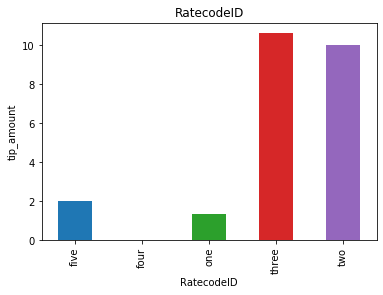

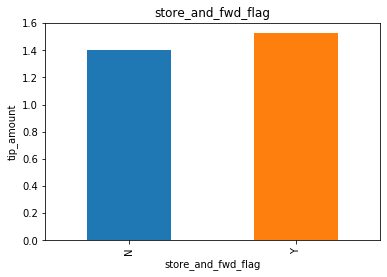

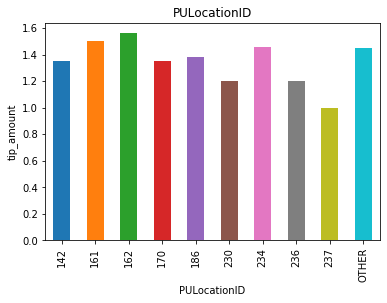

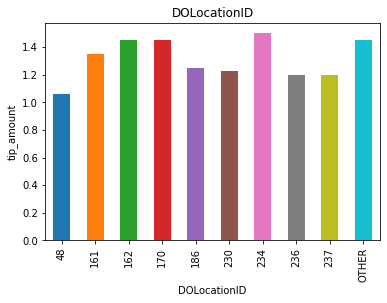

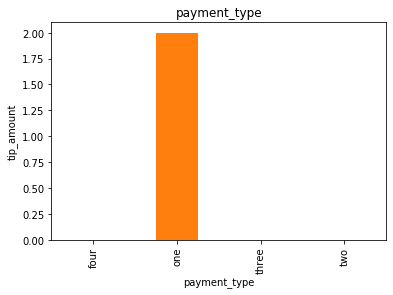

In [237]:
# is there a monotonic relationship between the labels and tip amount?
def analyse_vars(df, var):
    df = df.copy()
    df.groupby(var)['tip_amount'].median().plot.bar()
    plt.title(var)
    plt.ylabel('tip_amount')
    plt.show()
    
for var in cat_vars:
    analyse_vars(X_train, var)

### Feature scaling
- for linear models

In [238]:
features = [var for var in train_encoded.columns if var not in ['id', 'tip_amount']]

train_encoded[['id', 'tip_amount']].reset_index(drop=True)

,id,tip_amount
0,1,1.96
1,11,1.00
2,13,0.00
3,14,0.00
4,15,2.36
5,19,0.00
6,20,1.85
7,26,2.85
8,28,5.55
9,30,5.64


In [239]:
scaler = MinMaxScaler()
scaler.fit(train_encoded[features])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [245]:
train_features = [var for var in train_encoded.columns if var not in ['id', 'tip_amount']]
val_features = [var for var in val_encoded.columns if var not in ['id', 'tip_amount']]
test_features = [var for var in test_encoded.columns if var not in ['id', 'tip_amount']]

train_scaled = pd.concat([train_encoded[['id', 'tip_amount']].reset_index(drop=True),
                    pd.DataFrame(scaler.transform(train_encoded[train_features]), columns=train_features)],
                    axis=1)

val_scaled = pd.concat([val_encoded[['id', 'tip_amount']].reset_index(drop=True),
                    pd.DataFrame(scaler.transform(val_encoded[val_features]), columns=val_features)],
                    axis=1)

test_scaled = pd.concat([test_encoded[['id', 'tip_amount']].reset_index(drop=True),
                    pd.DataFrame(scaler.transform(test_encoded[test_features]), columns=test_features)],
                    axis=1)

In [211]:
X_train_scaled = pd.concat([X_train_encoded[['id', 'tip_amount']].reset_index(drop=True),
                    pd.DataFrame(scaler.transform(X_train_encoded[features]), columns=features)],
                    axis=1)

X_test_scaled = pd.concat([X_test_encoded[['id', 'tip_amount']].reset_index(drop=True),
                    pd.DataFrame(scaler.transform(X_test_encoded[features]), columns=features)],
                    axis=1)

KeyError: "['PULocationID_48'] not in index"

In [246]:
train_scaled.shape, val_scaled.shape, test_scaled.shape

((10081, 51), (9434, 51), (9233, 51))

In [247]:
train_scaled.head()

,id,tip_amount,VendorID_2,VendorID_1,passenger_count,trip_distance,RatecodeID_one,RatecodeID_two,RatecodeID_five,RatecodeID_three,RatecodeID_four,store_and_fwd_flag_N,store_and_fwd_flag_Y,PULocationID_OTHER,PULocationID_236,PULocationID_186,PULocationID_161,PULocationID_230,PULocationID_237,PULocationID_234,PULocationID_162,PULocationID_48,PULocationID_170,DOLocationID_236,DOLocationID_OTHER,DOLocationID_186,DOLocationID_48,DOLocationID_230,DOLocationID_170,DOLocationID_161,DOLocationID_234,DOLocationID_237,DOLocationID_162,payment_type_one,payment_type_two,payment_type_three,payment_type_four,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,total_amount,trip_seconds,pickup_hour,pickup_min,pickup_sec,dropoff_hour,dropoff_min,dropoff_sec,trip_day
0,1,1.96,1.0,0.0,0.2,0.049380,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.680321,0.000000,1.0,0.0,0.0,0.537155,0.006259,0.521739,0.169492,0.0,0.521739,0.338983,0.0,0.166667
1,11,1.00,1.0,0.0,0.0,0.072002,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.700391,0.222222,1.0,0.0,0.0,0.560787,0.006259,0.782609,0.203390,0.0,0.782609,0.372881,0.0,0.166667
2,13,0.00,0.0,1.0,0.0,0.024325,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.690859,0.222222,1.0,0.0,0.0,0.537656,0.009736,0.782609,0.474576,0.0,0.782609,0.728814,0.0,0.300000
3,14,0.00,1.0,0.0,0.0,0.075894,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.720873,0.000000,1.0,0.0,0.0,0.566045,0.009736,0.478261,0.067797,0.0,0.478261,0.322034,0.0,0.333333
4,15,2.36,1.0,0.0,0.0,0.051569,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.690859,0.222222,1.0,0.0,0.0,0.564592,0.007650,0.695652,0.745763,0.0,0.695652,0.949153,0.0,0.633333


In [248]:
train_scaled.isnull().sum()

id                       0
tip_amount               0
VendorID_2               0
VendorID_1               0
passenger_count          0
trip_distance            0
RatecodeID_one           0
RatecodeID_two           0
RatecodeID_five          0
RatecodeID_three         0
RatecodeID_four          0
store_and_fwd_flag_N     0
store_and_fwd_flag_Y     0
PULocationID_OTHER       0
PULocationID_236         0
PULocationID_186         0
PULocationID_161         0
PULocationID_230         0
PULocationID_237         0
PULocationID_234         0
PULocationID_162         0
PULocationID_48          0
PULocationID_170         0
DOLocationID_236         0
DOLocationID_OTHER       0
DOLocationID_186         0
DOLocationID_48          0
DOLocationID_230         0
DOLocationID_170         0
DOLocationID_161         0
DOLocationID_234         0
DOLocationID_237         0
DOLocationID_162         0
payment_type_one         0
payment_type_two         0
payment_type_three       0
payment_type_four        0
f

In [249]:
train_scaled.to_csv('train_scaled.csv', index=False)
val_scaled.to_csv('val_scaled.csv', index=False)
test_scaled.to_csv('test_scaled.csv', index=False)